In [1]:
import torch
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import numpy as np

from model import UNet
from datasets.dataset import LandcoverDataset


TEST_IMG_DIR = "data/landcover/test/images/"
TEST_MASK_DIR = "data/landcover/test/masks/"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 16

model = UNet(
    in_channels=3,
    n_classes=5,
    features=[64, 128, 256],
)

model.load_state_dict(torch.load("trained_models/model2.pth"))
model.to(DEVICE)

UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e

In [2]:
test_transforms = A.Compose(
    [
        A.Resize(height=64, width=64),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

test_dataset = LandcoverDataset(
    image_dir=TEST_IMG_DIR,
    mask_dir=TEST_MASK_DIR,
    transform=test_transforms,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

model.eval()

num_correct = 0
num_pixels = 0

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        num_correct += (preds == y.squeeze()).sum()
        num_pixels += torch.numel(preds)

print(
    f"Test Accuracy: {num_correct / num_pixels}"
)

Test Accuracy: 0.9245027303695679


torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
tensor(0.9802)


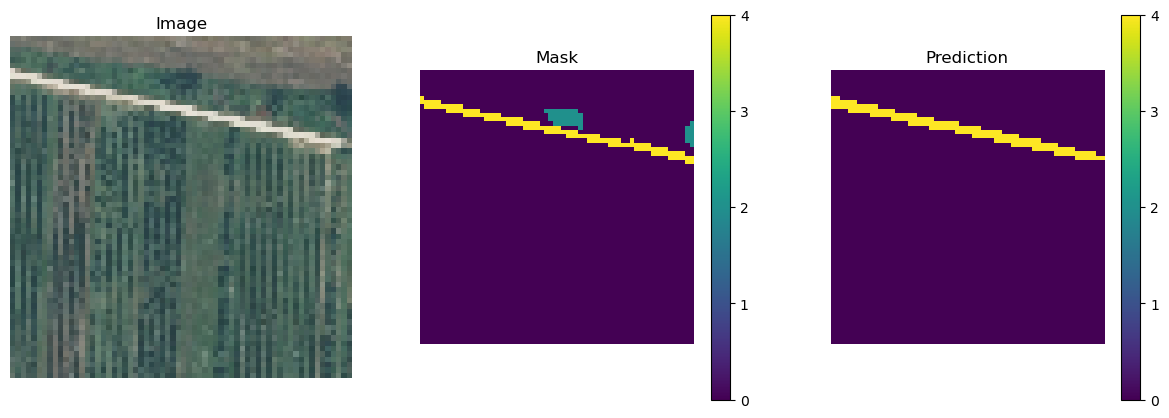

torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
tensor(0.9285)


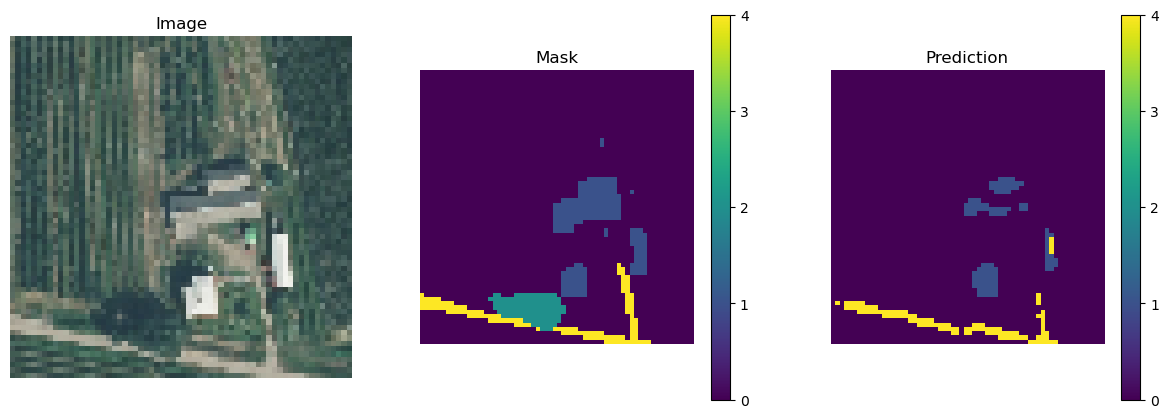

torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
tensor(0.8721)


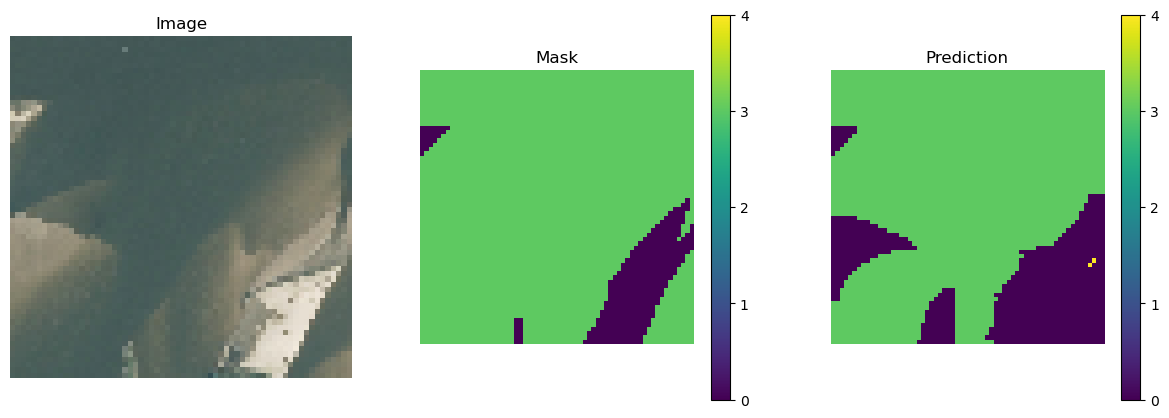

torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
tensor(0.7812)


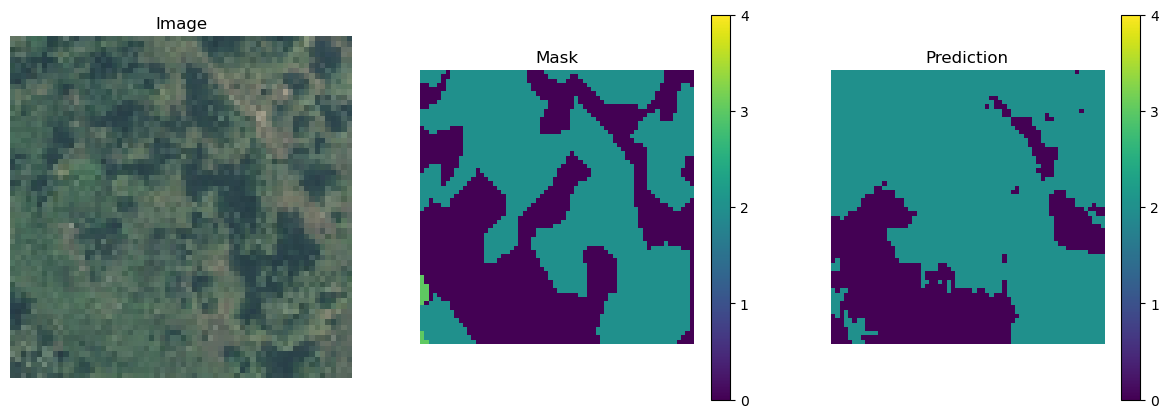

torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
tensor(0.8157)


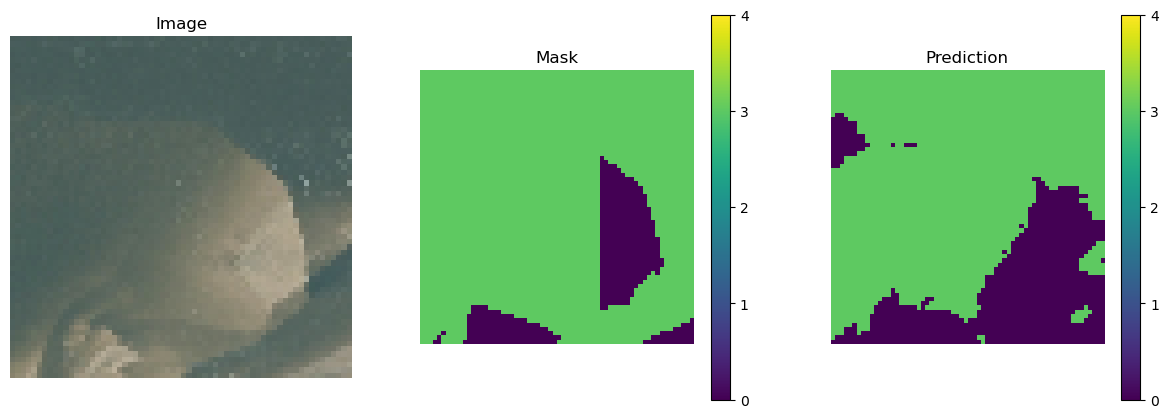

In [3]:
model.eval()
for i in range(5):
    image, mask = test_dataset[i + 200]
    image = image.unsqueeze(0)
    with torch.no_grad():
        image = image.to(DEVICE)
        logits = model(image)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        print(mask.shape, preds.shape)

        print((mask == preds.cpu()).sum() / torch.numel(mask))

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(np.transpose(image.squeeze(0).cpu(), (1, 2, 0)))
    axs[0].set_title("Image")

    mask = mask.squeeze()

    m = axs[1].imshow(mask, vmin=0, vmax=4)
    axs[1].set_title("Mask")
    plt.colorbar(m, ax=axs[1], ticks=[0, 1, 2, 3, 4])

    p = axs[2].imshow(preds.cpu().squeeze(0), vmin=0, vmax=4)
    axs[2].set_title("Prediction")
    plt.colorbar(p, ax=axs[2], ticks=[0, 1, 2, 3, 4])

    for ax in axs:
        ax.axis("off")

    plt.show()

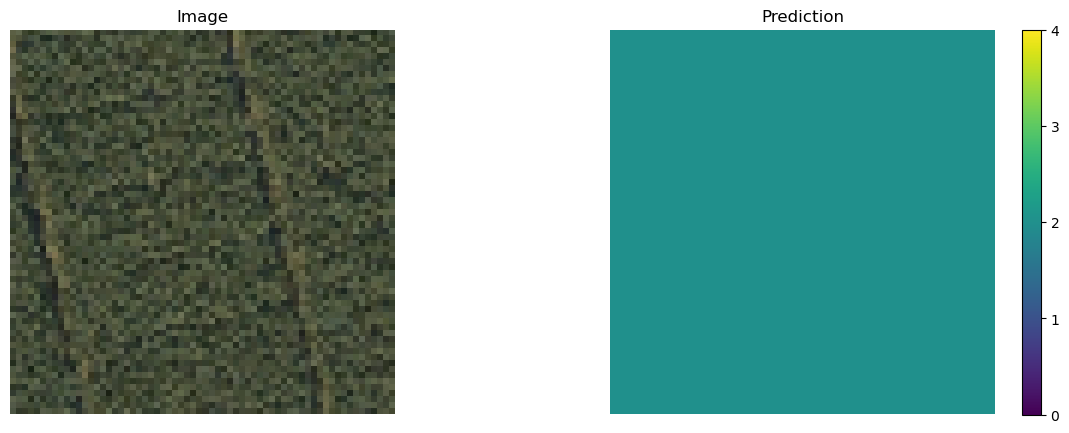

In [4]:
import cv2

file = "data/landcover/train/images/M-33-7-A-d-2-3_0.jpg"

image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = A.Compose(
    [
        A.Resize(height=64, width=64),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

image = transform(image=image)["image"]

image = image.unsqueeze(0)

model.eval()

with torch.no_grad():
    image = image.to(DEVICE)
    logits = model(image)
    probs = F.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(np.transpose(image.squeeze(0).cpu(), (1, 2, 0)))
axs[0].set_title("Image")

p = axs[1].imshow(preds.cpu().squeeze(0), vmin=0, vmax=4)
axs[1].set_title("Prediction")

plt.colorbar(p, ax=axs[1], ticks=[0, 1, 2, 3, 4])

for ax in axs:
    ax.axis("off")

plt.show()